In [1]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 
import datetime as dt

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import joblib

In [2]:
# method for saving the MinMaxScaler
def save_scaler(scaler, name):
    path = f"helper/{name}.joblib"
    joblib.dump(scaler, open(path, "wb"))

# method for loading the scaler
def load_scaler(name):
    path = f"helper/{name}.joblib"
    with open(path, 'rb') as file:
        scaler = joblib.load(file)
        return scaler

# method for saving the model
def save_model(model):
    path = "helper/model.h5"
    model.save(path, overwrite=True)

In [3]:
# Reading dataset from local library (data is not added to git)
RUN_NAME = 'AAPL_past_2'
ticker = "AAPL"

df = pd.read_csv(f'data/stocks/{ticker}.csv', parse_dates=['Date'])

# Calculating daily differences
df["Difference"] = df["Close"].diff()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,NaN
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,-0.026786
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,-0.035714
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,0.011161
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,0.013393


In [4]:
# Defining a function that will contain data in a specific date range
def specific_data(company, df, start = dt.datetime(1990,1,1), end = dt.datetime(2024,1,1)):
    date_filtered_data = df[(df['Date'] > start) & (df['Date'] < end)]
    return date_filtered_data

df = specific_data(ticker, df)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
2287,1990-01-02,1.258929,1.339286,1.250000,1.330357,1.078869,45799600,0.071429
2288,1990-01-03,1.357143,1.357143,1.339286,1.339286,1.086111,51998800,0.008929
2289,1990-01-04,1.366071,1.383929,1.330357,1.343750,1.089730,55378400,0.004464
2290,1990-01-05,1.348214,1.366071,1.321429,1.348214,1.093350,30828000,0.004464
2291,1990-01-08,1.339286,1.357143,1.321429,1.357143,1.100591,25393200,0.008929


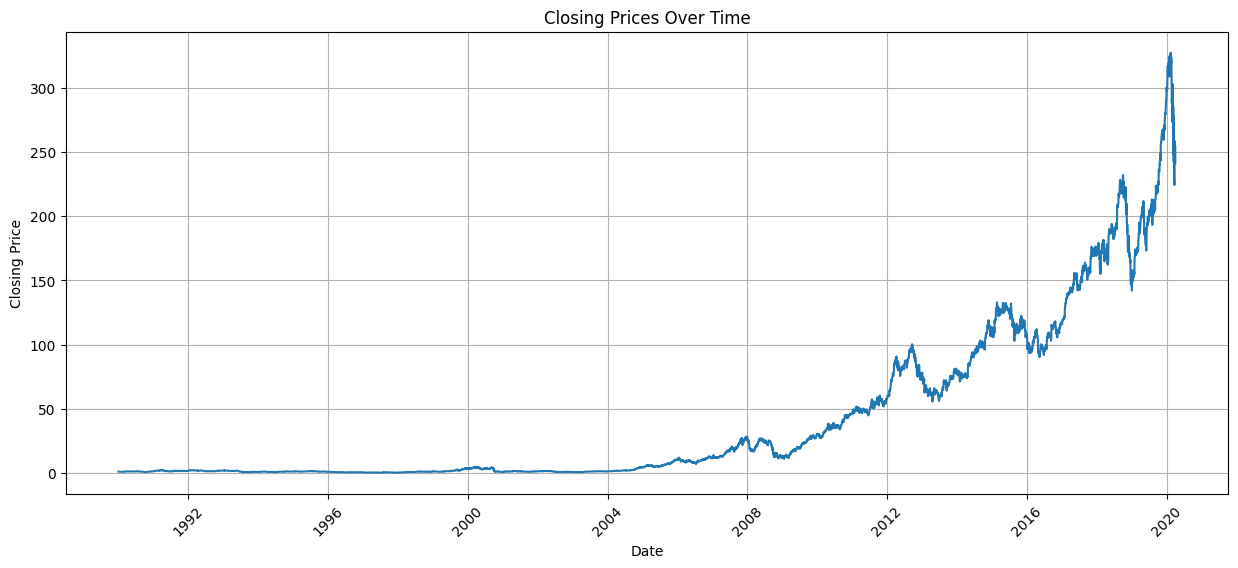

In [5]:
# Convert 'Date' column to datetime and printing out the loaded data to a plot
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

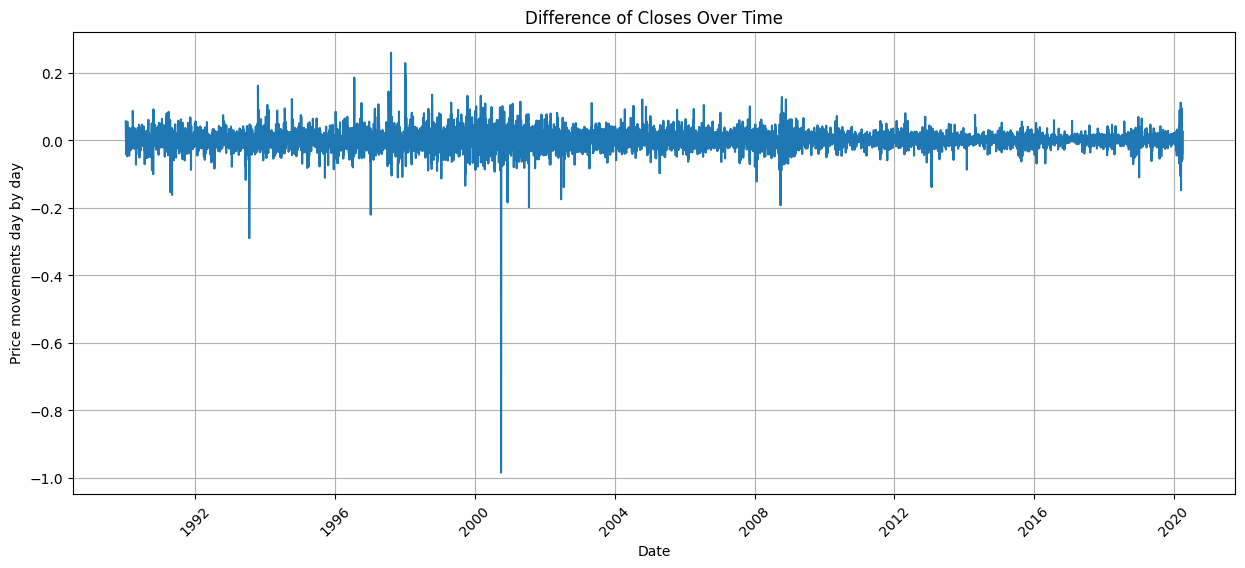

In [6]:
# Daily movement ratio to opening

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df["Difference"] / df["Open"])
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

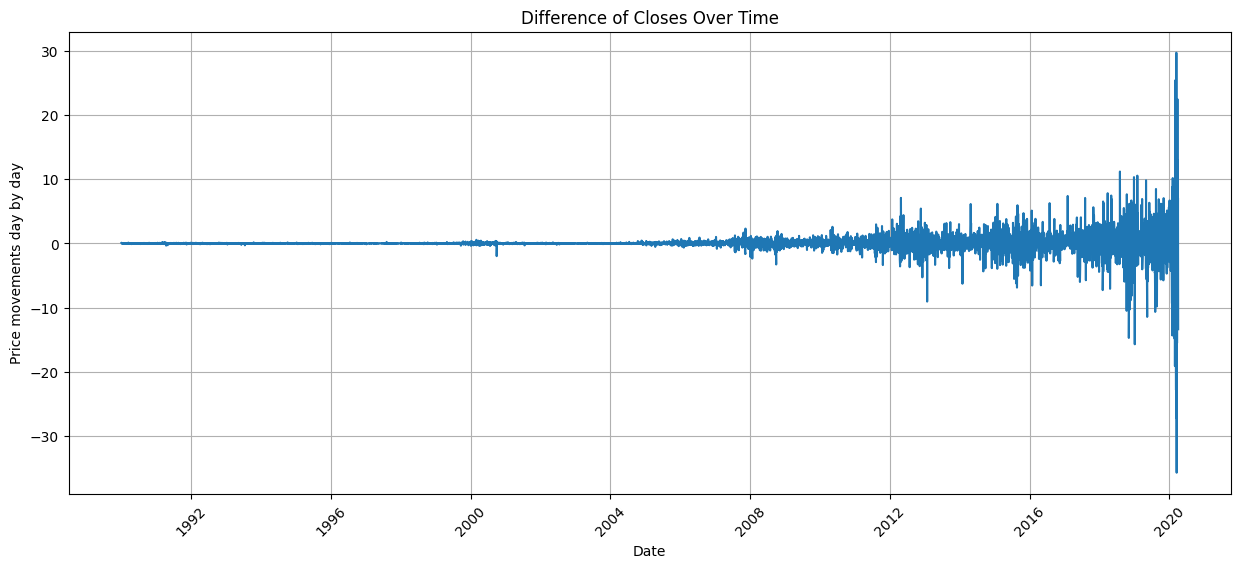

In [7]:
# daily movements in dollars

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Difference'])
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [8]:
# Splitting data to training and test sets
# Scaling training and testing data, then saving scalers

scaler = MinMaxScaler()
close_scaler = MinMaxScaler()
without_date = df.drop( "Date", axis="columns")

df_train, df_test = train_test_split(without_date, test_size=0.2, shuffle=False)

scaled_train = scaler.fit_transform(df_train.values)
scaled_test = scaler.transform(df_test.values)
close_scaler.fit(np.array(df_train["Close"].values).reshape(-1,1))

save_scaler(close_scaler, "close_scaler")
save_scaler(scaler, "scaler")

print(scaled_train.shape)
print(scaled_test.shape)

(6097, 7)
(1525, 7)


In [86]:
# Defining a window to look into the past, and creating actual training and testing sets with that sliding window

past = 14

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(past, len(scaled_train)):
    X_train.append(scaled_train[i - past:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(past, len(scaled_test)):
    X_test.append(scaled_test[i - past:i])
    y_test.append(scaled_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(6083, 14, 7)
(6083, 7)
Testing set size:-
(1511, 14, 7)
(1511, 7)


(None, None)

In [87]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 64 units, input shape, and return sequences
model.add(LSTM(units=64, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 64 units and return sequences
model.add(LSTM(units=64, activation="relu", return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 64 units
model.add(LSTM(units=64, activation="relu"))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(1))

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 14, 64)            18432     
                                                                 
 dropout_21 (Dropout)        (None, 14, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 14, 64)            33024     
                                                                 
 dropout_22 (Dropout)        (None, 14, 64)            0         
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [88]:
# Compiling model, defining loss function and optimizer, which determines learing rate

model.compile(loss='mse',optimizer='adam')

In [89]:
# Fitting the model

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
logger = keras.callbacks.TensorBoard(
        log_dir=f"logs/{RUN_NAME}",
        write_graph=True,
        histogram_freq=64
)

# Training our lstm model
model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=24,
          batch_size=8,
          verbose=1,
          callbacks= [early_stopping, logger])

save_model(model)

Epoch 1/24
609/609 [==============================] - 14s 18ms/step - loss: 0.0342 - val_loss: 0.0394
Epoch 2/24
609/609 [==============================] - 11s 18ms/step - loss: 0.0339 - val_loss: 0.0433
Epoch 3/24
609/609 [==============================] - 11s 18ms/step - loss: 0.0339 - val_loss: 0.0496
Epoch 4/24
609/609 [==============================] - 11s 17ms/step - loss: 0.0338 - val_loss: 0.0528
Epoch 5/24
609/609 [==============================] - 10s 16ms/step - loss: 0.0338 - val_loss: 0.0496
Epoch 6/24
609/609 [==============================] - 10s 16ms/step - loss: 0.0338 - val_loss: 0.0568
Epoch 7/24
609/609 [==============================] - 10s 17ms/step - loss: 0.0338 - val_loss: 0.0611
Epoch 8/24
609/609 [==============================] - 10s 16ms/step - loss: 0.0338 - val_loss: 0.0681
Epoch 9/24
609/609 [==============================] - 10s 16ms/step - loss: 0.0338 - val_loss: 0.0710
Epoch 10/24
609/609 [==============================] - 11s 17ms/step - loss: 0.033

In [90]:
# predict and check performance metrics

train_predict=model.predict(X_train, verbose=0)
test_predict=model.predict(X_test, verbose=0)

In [91]:
# Transform back to original form

loaded_scaler = load_scaler("close_scaler")

test_predict = loaded_scaler.inverse_transform(test_predict)
train_predict = loaded_scaler.inverse_transform(train_predict)

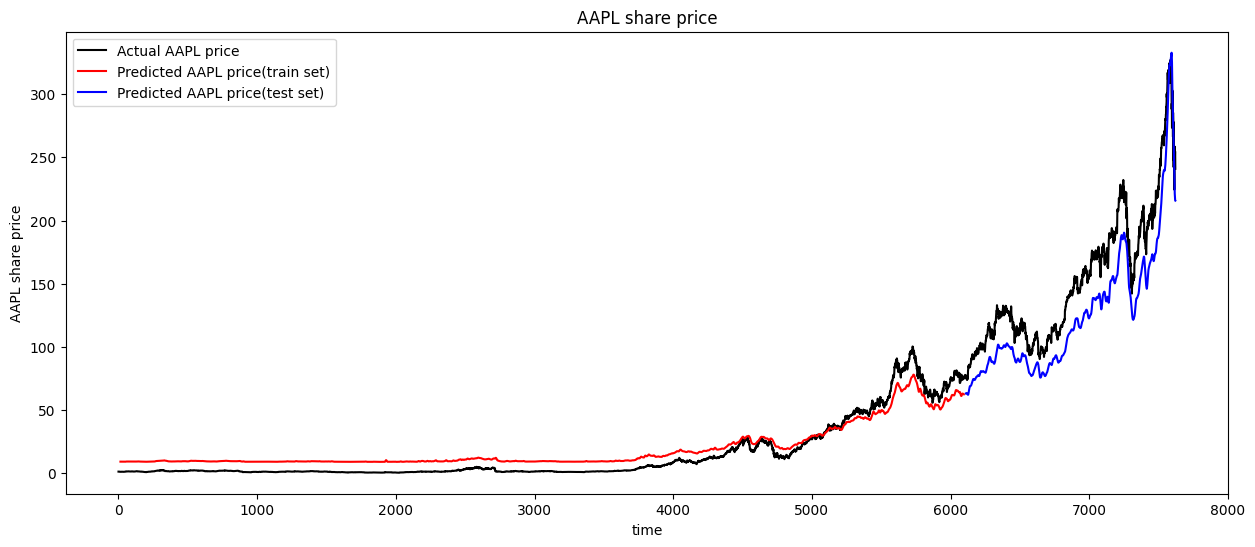

In [92]:
# Set the number of previous time steps to consider for plotting
look_back = past

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(df["Close"])
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(df["Close"])
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = np.array(df["Close"])

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {ticker} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {ticker} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {ticker} price(test set)")

plt.title(f"{ticker} share price")
plt.xlabel("time")
plt.ylabel(f"{ticker} share price")
plt.legend()
plt.show()

In [93]:
print(original_scaled_data.shape)
predicted = pd.concat([pd.DataFrame(train_predict), pd.DataFrame(test_predict)])
print(predicted)

(7622,)
               0
0       9.227416
1       9.224617
2       9.220448
3       9.215619
4       9.213942
...          ...
1506  221.179794
1507  218.938248
1508  217.626892
1509  215.861359
1510  215.724915

[7594 rows x 1 columns]


In [94]:
# Concatenate training and testing data to see how efficient it predicted

concatenated = pd.concat([df_train["Close"][look_back:], df_test["Close"][look_back:]])

combined = pd.concat(
[
    predicted, 
    pd.DataFrame(
        concatenated
    ).set_index(predicted.index)
], 
    axis=1, 
    ignore_index=False
)
combined.columns = ["Predicted", "Close"]
combined["Difference"] = combined["Close"].diff()
combined["Predicted difference"] = combined["Predicted"].diff()
combined["Same Direction"] = combined.apply(lambda x: x["Predicted difference"] * x["Difference"] > 0, axis=1)
print(combined)

       Predicted       Close  Difference  Predicted difference  Same Direction
0       9.227416    1.187500         NaN                   NaN           False
1       9.224617    1.205357    0.017857             -0.002799           False
2       9.220448    1.214286    0.008929             -0.004169           False
3       9.215619    1.218750    0.004464             -0.004829           False
4       9.213942    1.169643   -0.049107             -0.001678            True
...          ...         ...         ...                   ...             ...
1506  221.179794  258.440002   12.919998             -4.843719           False
1507  218.938248  247.740005  -10.699997             -2.241547            True
1508  217.626892  254.809998    7.069992             -1.311356           False
1509  215.861359  254.289993   -0.520004             -1.765533            True
1510  215.724915  240.910004  -13.379990             -0.136444            True

[7594 rows x 5 columns]


In [95]:
import collections
counter = collections.Counter(combined["Same Direction"])
print(counter)

Counter({False: 3809, True: 3785})


In [96]:
# predicting right direction for the stock to move

counter[True] / (counter[False] + counter[True])

0.4984198051092968